#import all necessary libraries for the machine learning project.

In [1]:
# import the necessary libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import tqdm
from sklearn import metrics, model_selection
# The libraries below are built-into python and are used to work with local storage and directories
import os
import glob

# Download the dataset using tf.keras.dataset

In [2]:
# download the required dataset
(x_train,y_train),(x_test,y_test)=tf.keras.datasets.fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [3]:
y_train=y_train.reshape(-1)
y_test = y_test.reshape(-1)

# Create Data Pipeline

In [4]:
# read the image
def get_image_tensor_from_path(image, label):
    image = tf.reshape(image,(28,28,1))
    image = tf.keras.layers.concatenate([image,image,image])
    
    image=tf.image.convert_image_dtype(image,tf.float32)
    

    label=tf.one_hot(label,depth=10) # create the onehot vecotr for the labels 

    return image, label

In [5]:
# test the read the image 
x,y=get_image_tensor_from_path(x_train[0],0)

tf.Tensor([1. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)


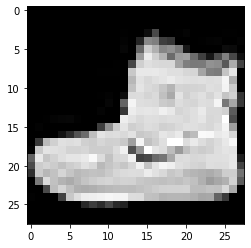

In [6]:
# plot image samples from the dataset
plt.imshow(x)
print(y)

In [12]:
# This is the same function that was defined in the CIFAR10 example
def augment_image(image, label):

    image = tf.image.random_flip_left_right(image)  # Randomly flip an image horizontally
    image = tf.image.random_brightness(image, max_delta=32.0 / 255.0)  # Adjust the brightness of images by a random factor
    image = tf.image.random_saturation(image, lower=0.5, upper=1.5)  # Adjust the saturation of RGB images by a random factor
    image = tf.clip_by_value(image,0.0,1.0)
    

    

    return image, label

In [13]:
# create the data pipeline
def create_data_pipeline(x, y, batch_size=32, training=False):
    data = tf.data.Dataset.from_tensor_slices((x, y))
    data = data.shuffle(50000)  # Shuffle the data, `2000` represnts the buffer size, read the documentation for more details


    # Convert image paths to image tensors using get_image_tensor_from_path
    data = data.map(get_image_tensor_from_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    if (training):  # If training == True then apply train preprocess on dataset, this makes sure that the validation dataset isn't augmented
        data = data.map(augment_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)  # Applying the augment_image function on dataset
    data = data.batch(batch_size)  # Create mini-batches for the specified size
    # This allows later elements to be prepared while the current element is being processed.
    data = data.prefetch(tf.data.experimental.AUTOTUNE)

    return data

In [14]:

# create the train pipleine 
train_dataset = create_data_pipeline(x_train,y_train, training=True)
# create the test pipeline
test_dataset = create_data_pipeline(x_test,y_test)

In [15]:
for x,y in train_dataset.take(2):
    print(y)
    print(x.shape)
    print(np.argmax(y,axis=-1))


tf.Tensor(
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]

#Create the model

In [16]:
# create the model class inheritance from the Model class 
tf.keras.backend.clear_session()
tf.random.set_seed(42)
class CNN_MODEL(tf.keras.Model):
    def __init__(self,class_number):
        super(CNN_MODEL,self).__init__()
        
        self.c1=tf.keras.layers.Conv2D(16,3,padding='same',activation=tf.nn.leaky_relu,)
        self.c2=tf.keras.layers.Conv2D(32,3,padding='same',activation=tf.nn.leaky_relu,)
        self.max_1= tf.keras.layers.MaxPooling2D()
        # add dropout layer
        self.dropout_1=tf.keras.layers.Dropout(0.2)
        self.c3=tf.keras.layers.Conv2D(64,3,padding='same',activation=tf.nn.leaky_relu)
        self.c4=tf.keras.layers.Conv2D(128,3,padding='same',activation=tf.nn.leaky_relu)
        self.max_2= tf.keras.layers.MaxPooling2D()
        # add dropout layer
        self.dropout_2=tf.keras.layers.Dropout(0.3)
        self.c5=tf.keras.layers.Conv2D(256,3,padding='same',activation=tf.nn.leaky_relu)

        
        self.D1=tf.keras.layers.Dense(512,activation=tf.nn.leaky_relu)
        # add dropout layer
        self.dropout_3=tf.keras.layers.Dropout(0.5)
        self.D2=tf.keras.layers.Dense(256,activation=tf.nn.leaky_relu)
        # add dropout layer
        self.dropout_4=tf.keras.layers.Dropout(0.4)
      
        self.out=tf.keras.layers.Dense(class_number)
    def call(self,x):
        x=self.c1(x)
        x=self.c2(x)
        x=self.max_1(x)
        x=self.dropout_1(x)
        x=self.dropout_1(x)
        x=self.c3(x)
        x=self.c4(x)
        x=self.max_2(x)
        x=self.dropout_2(x)
        x=self.dropout_2(x)
        x=self.c5(x)
        x=tf.reshape(x,(-1,7*7*256))
        x=self.D1(x)
        x=self.dropout_3(x)
        x=self.D2(x)
        x=self.dropout_4(x)
        x=self.out(x)
        x=tf.nn.softmax(x)
        return x 
# initial  the model
model=CNN_MODEL(class_number=10)
model.build((None,28,28,3))# build the model

In [17]:
model.summary()

Model: "cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  448       
                                                                 
 conv2d_1 (Conv2D)           multiple                  4640      
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 dropout (Dropout)           multiple                  0         
                                                                 
 conv2d_2 (Conv2D)           multiple                  18496     
                                                                 
 conv2d_3 (Conv2D)           multiple                  73856     
                                                         

In [18]:
# compile the model 
model.compile(
    optimizer=tf.keras.optimizers.Adam(), 
    loss=tf.keras.losses.CategoricalCrossentropy(),
     metrics=["accuracy"]
)

In [19]:
# train the model 
model.fit(train_dataset, epochs=50, 
          validation_data=test_dataset)

Epoch 1/50
1875/1875 [==============================] - 32s 11ms/step - loss: 0.5295 - accuracy: 0.8079 - val_loss: 0.3637 - val_accuracy: 0.8626
Epoch 2/50
1875/1875 [==============================] - 19s 10ms/step - loss: 0.3921 - accuracy: 0.8590 - val_loss: 0.3073 - val_accuracy: 0.8871
Epoch 3/50
1875/1875 [==============================] - 19s 10ms/step - loss: 0.3662 - accuracy: 0.8673 - val_loss: 0.2756 - val_accuracy: 0.9003
Epoch 4/50
1875/1875 [==============================] - 19s 10ms/step - loss: 0.3555 - accuracy: 0.8718 - val_loss: 0.2882 - val_accuracy: 0.8935
Epoch 5/50
1875/1875 [==============================] - 19s 10ms/step - loss: 0.3535 - accuracy: 0.8751 - val_loss: 0.3109 - val_accuracy: 0.8943
Epoch 6/50
1875/1875 [==============================] - 19s 10ms/step - loss: 0.3492 - accuracy: 0.8767 - val_loss: 0.2722 - val_accuracy: 0.8984
Epoch 7/50
1875/1875 [==============================] - 19s 10ms/step - loss: 0.3447 - accuracy: 0.8775 - val_loss: 0.2825 -

# Model Evaluation 

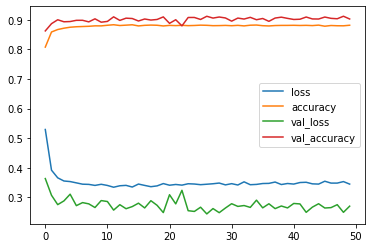

In [20]:
pd.DataFrame(model.history.history).plot()

In [21]:
preds=np.array([])
ys=np.array([])
for x,y in tqdm.tqdm(test_dataset):
    pred = np.argmax( model.predict(x),axis=-1)
    y=np.argmax( y,axis=-1)
    preds=np.append(preds,pred)
    ys=np.append(ys,y)

100%|██████████| 313/313 [00:20<00:00, 15.28it/s]


accuracy_score: 0.9029
precision_score: 0.9055750396022193
recall_score: 0.9029
f1_score: 0.9019869060804762


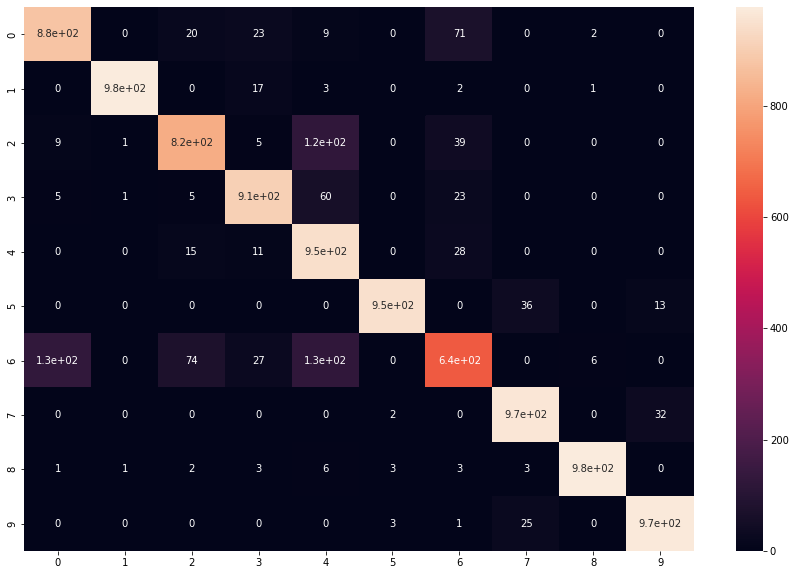

In [22]:
accuracy_score=metrics.accuracy_score(y_true=ys,y_pred=preds)
precision_score=metrics.precision_score(ys,preds,average='weighted')
recall_score=metrics.recall_score(ys,preds,average='weighted')
f1_score=metrics.f1_score(ys,preds,average='weighted')
confion_metrix=metrics.confusion_matrix(ys,preds)
print('accuracy_score:',accuracy_score)
print('precision_score:',precision_score)
print('recall_score:',recall_score)
print('f1_score:',f1_score)
plt.figure(figsize=(15,10))
sn.heatmap(confion_metrix,annot=True,)